# Gradient smoothing

Ce notebook est dédiée à la vérification de l'équivalence entre le lissage gaussien proposé dans scipy.ndimage et les filtres rbf qui eux fonctionnent sur des grilles non régulières.
 
- Import required modules

In [26]:
import logging
import os
from pathlib import Path

import gstools as gs
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.interpolate import RBFInterpolator

- Set-up logging level

In [27]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("this is a test")

INFO:root:this is a test


- Check package/software versions

In [28]:
pyrtid.utils.show_versions()

INFO:root:Current version = 0.1.2

INFO:root:Used packages version:

INFO:root:iterative_ensemble_smoother = 0.1.1
INFO:root:gstools                     = 1.5.1
INFO:root:matplotlib                  = 3.7.2
INFO:root:nested_grid_plotter         = 1.0.0
INFO:root:numdiftools                 = 0.9.41
INFO:root:numpy                       = 1.25.2
INFO:root:pyesmda                     = 0.4.3
INFO:root:pypcga                      = 0.1.0
INFO:root:scipy                       = 1.10.1
INFO:root:sksparse                    = 0.4.12
INFO:root:stochopy                    = 2.3.0


- Create a directory to store the exported figures

In [29]:
ipynb_path = os.path.dirname(os.path.realpath("__file__"))
fig_save_path = Path(ipynb_path, "exported_figures")
fig_save_path.mkdir(parents=True, exist_ok=True)  # make sure that the directory exists

- Define some configurations for the plots

In [30]:
# Some configs for the plots
new_rc_params = {
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "DejaVu Sans"],
    "font.size": 16,
    "text.usetex": False,
    "savefig.format": "svg",
    "svg.fonttype": "none",  # to store text as text, not as path
    "savefig.facecolor": "w",
    "savefig.edgecolor": "k",
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "figure.facecolor": "w",
    "axes.facecolor": "w",
}
csfont = {"fontname": "Comic Sans MS"}
hfont = {"fontname": "Helvetica"}
plt.plot()
plt.close()  # required for the plot to update
plt.rcParams.update(new_rc_params)

## Create a random field with some noise

In [31]:
dx = 10
dy = 10
nx = 100
ny = 80

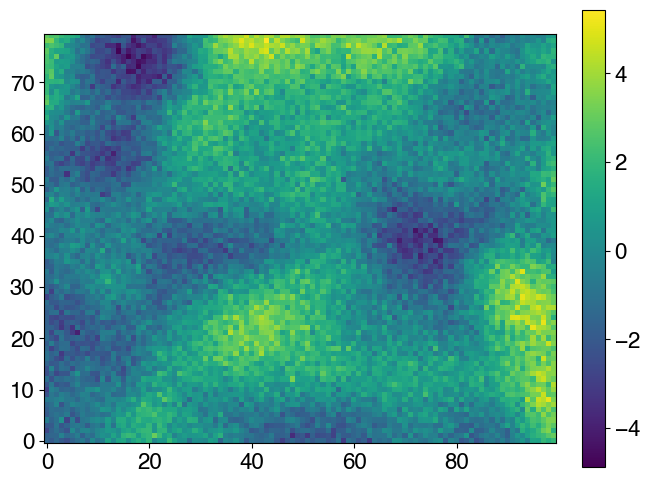

In [32]:
_seed = gs.random.MasterRNG(2023)

# structured field with a size 100x100 and a grid-size of 1x1
x = range(nx)
y = range(ny)
model = gs.Gaussian(dim=2, var=2, len_scale=10, nugget=0.4)
srf = gs.SRF(model)
srf((x, y), mesh_type="structured")
field = srf[0]

plt.imshow(field.T, origin="lower")
plt.colorbar()

# Gaussian smoothing with gaussian_filter

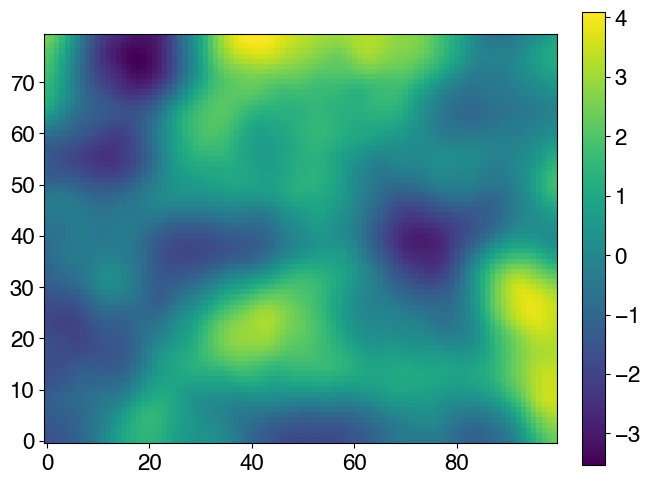

In [33]:
gf_field = sp.ndimage.gaussian_filter(field, sigma=2, order=0)

plt.imshow(gf_field.T, origin="lower")
plt.colorbar()

# Gaussian filtering with rbf interpolate

In [64]:
# Points coordinates
x = np.linspace(0.0 + dx / 2.0, nx * dx - dx / 2.0, nx)
y = np.linspace(0.0 + dy / 2.0, ny * dy - dy / 2.0, ny)
XX, YY = np.meshgrid(x, y)
pts = np.hstack((XX.ravel()[:, np.newaxis], YY.ravel()[:, np.newaxis]))

rbfi = RBFInterpolator(
    pts,
    field.ravel("F"),
    kernel="gaussian",
    epsilon=2.0,
    smoothing=1000.0,
    neighbors=20,
)  # radial basis function interpolator instance

rbf_field = rbfi(pts).reshape(ny, nx).T

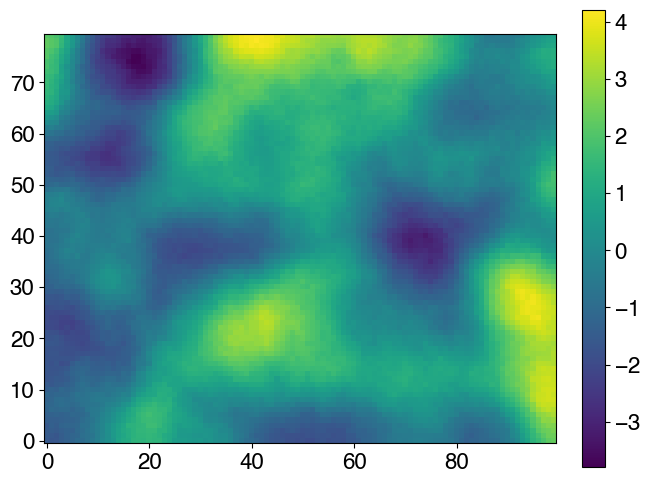

In [65]:
plt.imshow(rbf_field.T, origin="lower")
plt.colorbar()

In [70]:
rbfi2 = RBFInterpolator(
    pts, field.ravel("F"), smoothing=2, neighbors=10, degree=2
)  # radial basis function interpolator instance

rbf_field2 = rbfi2(pts).reshape(ny, nx).T

# Note about epsilon: average distance between nodes

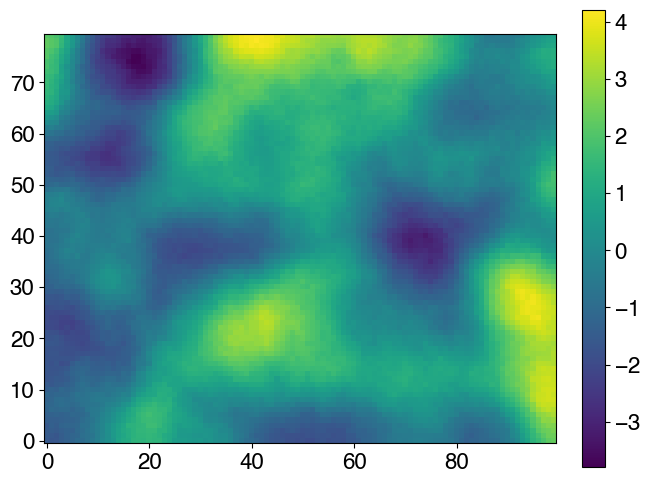

In [71]:
plt.imshow(rbf_field.T, origin="lower")
plt.colorbar()

In [68]:
# See how to implement with https://github.com/JoeyforJoy/Eigen-Based-KD-Tree -> implement a neighboors like algorithms